In [1]:
# Cell 1 — Load X, y, groups (LOCAL)

import numpy as np

# Load arrays (from same folder)
X = np.load("X.npy", mmap_mode="r")
y = np.load("y.npy")
groups = np.load("groups.npy")

print("X shape:", X.shape)
print("y shape:", y.shape)
print("groups shape:", groups.shape)

print("Unique labels:", np.unique(y))
print("Number of subjects:", len(np.unique(groups)))

X shape: (5964, 40, 1536)
y shape: (5964,)
groups shape: (5964,)
Unique labels: [0 1]
Number of subjects: 31


In [2]:
# Cell 2 — Reshape for EEGNet

X_eegnet = X[..., np.newaxis]

print("EEGNet input shape:", X_eegnet.shape)

EEGNet input shape: (5964, 40, 1536, 1)


In [3]:
# Cell 3 — EEGNet Model Definition

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
    BatchNormalization, Activation, AveragePooling2D,
    Dropout, Flatten, Dense
)
from tensorflow.keras.constraints import max_norm


def build_eegnet(n_channels, n_samples):
    inputs = Input(shape=(n_channels, n_samples, 1))

    # Block 1
    x = Conv2D(
        filters=8,
        kernel_size=(1, 64),
        padding="same",
        use_bias=False
    )(inputs)
    x = BatchNormalization()(x)

    x = DepthwiseConv2D(
        kernel_size=(n_channels, 1),
        depth_multiplier=2,
        use_bias=False,
        depthwise_constraint=max_norm(1.0)
    )(x)
    x = BatchNormalization()(x)
    x = Activation("elu")(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(0.5)(x)

    # Block 2
    x = SeparableConv2D(
        filters=16,
        kernel_size=(1, 16),
        padding="same",
        use_bias=False
    )(x)
    x = BatchNormalization()(x)
    x = Activation("elu")(x)
    x = AveragePooling2D((1, 8))(x)
    x = Dropout(0.5)(x)

    # Classifier
    x = Flatten()(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    return model


# Sanity check
model = build_eegnet(
    n_channels=X_eegnet.shape[1],
    n_samples=X_eegnet.shape[2]
)
model.summary()

/Users/mahir/Desktop/PBL4_EEG_PD/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 1536, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 40, 1536, 8)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 1536, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 1536, 16)    │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 1536, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 1536, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 384, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 384, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 384, 16)     │           512 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 384, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 384, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 48, 16)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 48, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593 (10.13 KB)

 Trainable params: 2,513 (9.82 KB)

 Non-trainable params: 80 (320.00 B)

In [4]:
# Cell 4 — STRICT LOSO with Resume + Checkpointing (LOCAL)

import os
import numpy as np
import tensorflow as tf

# ---------- Paths ----------
BASE_DIR = "EEGNet_LOSO"
os.makedirs(BASE_DIR, exist_ok=True)

RESULTS_PATH = os.path.join(BASE_DIR, "loso_results.npy")
DONE_PATH = os.path.join(BASE_DIR, "completed_subjects.txt")

# ---------- Resume state ----------
if os.path.exists(DONE_PATH):
    with open(DONE_PATH, "r") as f:
        completed_subjects = set(line.strip() for line in f)
else:
    completed_subjects = set()

if os.path.exists(RESULTS_PATH):
    results = list(np.load(RESULTS_PATH, allow_pickle=True))
else:
    results = []

subjects = np.unique(groups)

print("Total subjects:", len(subjects))
print("Already completed:", len(completed_subjects))

# ---------- LOSO Loop ----------
for test_sub in subjects:

    if test_sub in completed_subjects:
        print(f"[SKIP] {test_sub}")
        continue

    print(f"\n[TRAINING] Test subject:", test_sub)

    # STRICT subject split
    train_idx = groups != test_sub
    test_idx = groups == test_sub

    X_train = X_eegnet[train_idx]
    y_train = y[train_idx]
    X_test = X_eegnet[test_idx]
    y_test = y[test_idx]

    # Fresh model (NO leakage)
    model = build_eegnet(
        n_channels=X_eegnet.shape[1],
        n_samples=X_eegnet.shape[2]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy"
    )

    # Per-subject checkpoint
    ckpt_path = os.path.join(BASE_DIR, f"{test_sub}.weights.h5")
    ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=0
    )

    # Train (CPU-safe)
    model.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=64,
        verbose=0,
        callbacks=[ckpt_cb]
    )

    # Load best weights
    model.load_weights(ckpt_path)

    # Predict
    y_prob = model.predict(X_test, verbose=0).ravel()

    # Save raw outputs ONLY
    results.append({
        "subject": test_sub,
        "y_true": y_test,
        "y_prob": y_prob
    })

    # Immediate checkpoint
    np.save(RESULTS_PATH, results)

    with open(DONE_PATH, "a") as f:
        f.write(test_sub + "\n")

    completed_subjects.add(test_sub)

    print(f"[DONE] {test_sub} | windows:", len(y_test))

print("\nLOSO TRAINING COMPLETE")
print("Results saved to:", RESULTS_PATH)

Total subjects: 31
Already completed: 30
[SKIP] sub-hc1
[SKIP] sub-hc10
[SKIP] sub-hc18
[SKIP] sub-hc2
[SKIP] sub-hc20
[SKIP] sub-hc21
[SKIP] sub-hc24
[SKIP] sub-hc25
[SKIP] sub-hc29
[SKIP] sub-hc30
[SKIP] sub-hc31
[SKIP] sub-hc32
[SKIP] sub-hc33
[SKIP] sub-hc4
[SKIP] sub-hc7
[SKIP] sub-hc8
[SKIP] sub-pd11
[SKIP] sub-pd12
[SKIP] sub-pd13
[SKIP] sub-pd14
[SKIP] sub-pd16
[SKIP] sub-pd17
[SKIP] sub-pd19
[SKIP] sub-pd22
[SKIP] sub-pd23
[SKIP] sub-pd26
[SKIP] sub-pd28
[SKIP] sub-pd3
[SKIP] sub-pd5
[SKIP] sub-pd6

[TRAINING] Test subject: sub-pd9
[DONE] sub-pd9 | windows: 249

LOSO TRAINING COMPLETE
Results saved to: EEGNet_LOSO/loso_results.npy


In [5]:
# Cell 5 — Load LOSO results (NO training)

import numpy as np

results = list(np.load("EEGNet_LOSO/loso_results.npy", allow_pickle=True))

print("Number of subjects in results:", len(results))

# Check one entry
sample = results[0]
print("Keys:", sample.keys())
print("Subject:", sample["subject"])
print("Windows:", len(sample["y_true"]))

Number of subjects in results: 31
Keys: dict_keys(['subject', 'y_true', 'y_prob'])
Subject: sub-hc1
Windows: 126


In [6]:
# Cell 6 — Window-level Balanced Accuracy & AUC

from sklearn.metrics import balanced_accuracy_score, roc_auc_score
import numpy as np

# Concatenate all windows across subjects
y_true_all = np.concatenate([r["y_true"] for r in results])
y_prob_all = np.concatenate([r["y_prob"] for r in results])

# Binary predictions at threshold 0.5
y_pred_all = (y_prob_all >= 0.5).astype(int)

bal_acc_window = balanced_accuracy_score(y_true_all, y_pred_all)
auc_window = roc_auc_score(y_true_all, y_prob_all)

print("Window-level Balanced Accuracy:", round(bal_acc_window, 4))
print("Window-level AUC:", round(auc_window, 4))
print("Total windows:", len(y_true_all))

Window-level Balanced Accuracy: 0.7466
Window-level AUC: 0.7893
Total windows: 5964


In [7]:
# Cell 7 — Subject-level aggregation & metrics

from sklearn.metrics import balanced_accuracy_score, roc_auc_score
import numpy as np

subjects = []
y_true_subj = []
y_prob_subj = []

for r in results:
    subjects.append(r["subject"])
    
    # All windows of a subject have same true label
    y_true_subj.append(int(r["y_true"][0]))
    
    # Aggregate probabilities (mean)
    y_prob_subj.append(np.mean(r["y_prob"]))

y_true_subj = np.array(y_true_subj)
y_prob_subj = np.array(y_prob_subj)

y_pred_subj = (y_prob_subj >= 0.5).astype(int)

bal_acc_subj = balanced_accuracy_score(y_true_subj, y_pred_subj)
auc_subj = roc_auc_score(y_true_subj, y_prob_subj)

print("Subject-level Balanced Accuracy:", round(bal_acc_subj, 4))
print("Subject-level AUC:", round(auc_subj, 4))
print("Subjects:", len(y_true_subj))

Subject-level Balanced Accuracy: 0.7458
Subject-level AUC: 0.7875
Subjects: 31


## Baseline ML Experiment (PSD + SVM, LOSO)

In [2]:
# ML Cell 1 — Load data for classical ML baseline

import numpy as np

# Load data (same files used for EEGNet)
X = np.load("X.npy", mmap_mode="r")   # shape: (windows, channels, samples)
y = np.load("y.npy")                  # window labels
groups = np.load("groups.npy")        # subject IDs per window

print("X shape:", X.shape)
print("y shape:", y.shape)
print("groups shape:", groups.shape)

print("Unique labels:", np.unique(y))
print("Number of subjects:", len(np.unique(groups)))

X shape: (5964, 40, 1536)
y shape: (5964,)
groups shape: (5964,)
Unique labels: [0 1]
Number of subjects: 31


In [3]:
# ML Cell 2 — Bandpower feature extraction (SAVE FEATURES)

import numpy as np
from scipy.signal import welch
import os

# Parameters
sfreq = 512
bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta":  (13, 30),
    "gamma": (30, 40)
}

def bandpower_features(epoch, sfreq, bands):
    """
    epoch: shape (channels, samples)
    returns: feature vector (channels × bands)
    """
    feats = []
    for ch in epoch:
        freqs, psd = welch(ch, fs=sfreq, nperseg=sfreq*2)
        for low, high in bands.values():
            mask = (freqs >= low) & (freqs <= high)
            feats.append(np.mean(psd[mask]))
    return np.array(feats)

# Feature extraction loop
X_feats = []
for i in range(X.shape[0]):
    X_feats.append(bandpower_features(X[i], sfreq, bands))
    if i % 500 == 0:
        print(f"Processed {i}/{X.shape[0]} windows")

X_feats = np.array(X_feats)

print("Feature matrix shape:", X_feats.shape)

# Save features immediately
os.makedirs("ML_BASELINE", exist_ok=True)
np.save("ML_BASELINE/X_bandpower.npy", X_feats)
np.save("ML_BASELINE/y.npy", y)
np.save("ML_BASELINE/groups.npy", groups)

print("Bandpower features saved in ML_BASELINE/")

Processed 0/5964 windows
Processed 500/5964 windows
Processed 1000/5964 windows
Processed 1500/5964 windows
Processed 2000/5964 windows
Processed 2500/5964 windows
Processed 3000/5964 windows
Processed 3500/5964 windows
Processed 4000/5964 windows
Processed 4500/5964 windows
Processed 5000/5964 windows
Processed 5500/5964 windows
Feature matrix shape: (5964, 200)
Bandpower features saved in ML_BASELINE/


In [5]:
# ML Cell 3 — LOSO with SVM (SAVE RESULTS)

import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
import os
import json

# Load saved features
X_feats = np.load("ML_BASELINE/X_bandpower.npy")
y = np.load("ML_BASELINE/y.npy")
groups = np.load("ML_BASELINE/groups.npy")

subjects = np.unique(groups)
print("Total subjects:", len(subjects))

results_ml = []

for sub in subjects:
    print("Testing subject:", sub)
    
    train_idx = groups != sub
    test_idx = groups == sub
    
    X_train = X_feats[train_idx]
    y_train = y[train_idx]
    X_test = X_feats[test_idx]
    y_test = y[test_idx]
    
    # Pipeline: scaling + SVM
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", probability=True))
    ])
    
    clf.fit(X_train, y_train)
    
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    results_ml.append({
        "subject": sub,
        "y_true": y_test,
        "y_prob": y_prob
    })

# Save raw ML results
np.save("ML_BASELINE/ml_results.npy", results_ml)
print("Saved: ML_BASELINE/ml_results.npy")

# ---- Compute subject-level metrics ----
y_true_sub = []
y_prob_sub = []

for r in results_ml:
    y_true_sub.append(int(r["y_true"][0]))
    y_prob_sub.append(np.mean(r["y_prob"]))

y_true_sub = np.array(y_true_sub)
y_prob_sub = np.array(y_prob_sub)
y_pred_sub = (y_prob_sub >= 0.5).astype(int)

bal_acc = balanced_accuracy_score(y_true_sub, y_pred_sub)
auc = roc_auc_score(y_true_sub, y_prob_sub)

metrics = {
    "subject_level_balanced_accuracy": float(bal_acc),
    "subject_level_auc": float(auc),
    "n_subjects": int(len(subjects))
}

with open("ML_BASELINE/ml_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("ML Subject-level Balanced Accuracy:", round(bal_acc, 4))
print("ML Subject-level AUC:", round(auc, 4))
print("Metrics saved: ML_BASELINE/ml_metrics.json")

Total subjects: 31
Testing subject: sub-hc1
Testing subject: sub-hc10
Testing subject: sub-hc18
Testing subject: sub-hc2
Testing subject: sub-hc20
Testing subject: sub-hc21
Testing subject: sub-hc24
Testing subject: sub-hc25
Testing subject: sub-hc29
Testing subject: sub-hc30
Testing subject: sub-hc31
Testing subject: sub-hc32
Testing subject: sub-hc33
Testing subject: sub-hc4
Testing subject: sub-hc7
Testing subject: sub-hc8
Testing subject: sub-pd11
Testing subject: sub-pd12
Testing subject: sub-pd13
Testing subject: sub-pd14
Testing subject: sub-pd16
Testing subject: sub-pd17
Testing subject: sub-pd19
Testing subject: sub-pd22
Testing subject: sub-pd23
Testing subject: sub-pd26
Testing subject: sub-pd28
Testing subject: sub-pd3
Testing subject: sub-pd5
Testing subject: sub-pd6
Testing subject: sub-pd9
Saved: ML_BASELINE/ml_results.npy
ML Subject-level Balanced Accuracy: 0.7146
ML Subject-level AUC: 0.65
Metrics saved: ML_BASELINE/ml_metrics.json


In [6]:
import os

files_to_check = [
    "EEGNet_LOSO/loso_results.npy",
    "ML_BASELINE/ml_results.npy",
    "ML_BASELINE/ml_metrics.json"
]

for f in files_to_check:
    if os.path.exists(f):
        print(f"FOUND: {f}")
    else:
        print(f"MISSING: {f}")

FOUND: EEGNet_LOSO/loso_results.npy
FOUND: ML_BASELINE/ml_results.npy
FOUND: ML_BASELINE/ml_metrics.json


In [7]:
# Cell CM-1 — Load EEGNet LOSO results

import numpy as np

results = list(np.load("EEGNet_LOSO/loso_results.npy", allow_pickle=True))

print("Subjects in results:", len(results))

# Prepare subject-level arrays
y_true_subj = []
y_prob_subj = []

for r in results:
    y_true_subj.append(int(r["y_true"][0]))   # same label for all windows of subject
    y_prob_subj.append(np.mean(r["y_prob"]))  # mean probability per subject

y_true_subj = np.array(y_true_subj)
y_prob_subj = np.array(y_prob_subj)
y_pred_subj = (y_prob_subj >= 0.5).astype(int)

print("y_true_subj shape:", y_true_subj.shape)
print("y_pred_subj shape:", y_pred_subj.shape)
print("Unique true labels:", np.unique(y_true_subj))
print("Unique predicted labels:", np.unique(y_pred_subj))

Subjects in results: 31
y_true_subj shape: (31,)
y_pred_subj shape: (31,)
Unique true labels: [0 1]
Unique predicted labels: [0 1]


In [8]:
# Cell CM-2 — Confusion matrix and clinical metrics

from sklearn.metrics import confusion_matrix

# Confusion matrix: rows = true, cols = predicted
cm = confusion_matrix(y_true_subj, y_pred_subj)

tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix (rows=true, cols=pred):")
print(cm)
print()

print("TN (HC→HC):", tn)
print("FP (HC→PD):", fp)
print("FN (PD→HC):", fn)
print("TP (PD→PD):", tp)

# Sensitivity = TP / (TP + FN)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

# Specificity = TN / (TN + FP)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print()
print("Sensitivity (PD correctly detected):", round(sensitivity, 4))
print("Specificity (HC correctly detected):", round(specificity, 4))

Confusion Matrix (rows=true, cols=pred):
[[10  6]
 [ 2 13]]

TN (HC→HC): 10
FP (HC→PD): 6
FN (PD→HC): 2
TP (PD→PD): 13

Sensitivity (PD correctly detected): 0.8667
Specificity (HC correctly detected): 0.625


In [9]:
# Cell CI-1 — 95% Confidence Intervals (Bootstrap)

import numpy as np
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

rng = np.random.default_rng(42)
n_boot = 2000

bal_acc_samples = []
auc_samples = []

n = len(y_true_subj)

for _ in range(n_boot):
    idx = rng.integers(0, n, n)   # resample subjects with replacement
    
    y_true_b = y_true_subj[idx]
    y_pred_b = y_pred_subj[idx]
    y_prob_b = y_prob_subj[idx]
    
    bal_acc_samples.append(balanced_accuracy_score(y_true_b, y_pred_b))
    auc_samples.append(roc_auc_score(y_true_b, y_prob_b))

bal_acc_samples = np.array(bal_acc_samples)
auc_samples = np.array(auc_samples)

bal_ci = np.percentile(bal_acc_samples, [2.5, 97.5])
auc_ci = np.percentile(auc_samples, [2.5, 97.5])

print("Balanced Accuracy 95% CI:", np.round(bal_ci, 4))
print("AUC 95% CI:", np.round(auc_ci, 4))

Balanced Accuracy 95% CI: [0.5855 0.8841]
AUC 95% CI: [0.6009 0.9316]


In [10]:
# Cell XAI-1 — Band importance using mutual information

import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Load bandpower features and labels
X_feats = np.load("ML_BASELINE/X_bandpower.npy")   # (windows, 200)
y = np.load("ML_BASELINE/y.npy")

# 40 channels × 5 bands = 200 features
n_channels = 40
n_bands = 5
band_names = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

# Compute mutual information per feature
mi = mutual_info_classif(X_feats, y, random_state=42)

# Reshape: (channels, bands)
mi = mi.reshape(n_channels, n_bands)

# Average across channels → band importance
band_importance = mi.mean(axis=0)

print("Band importance (higher = more informative):")
for name, val in zip(band_names, band_importance):
    print(f"{name}: {val:.4f}")

Band importance (higher = more informative):
Delta: 0.0135
Theta: 0.0461
Alpha: 0.0371
Beta: 0.0462
Gamma: 0.0415


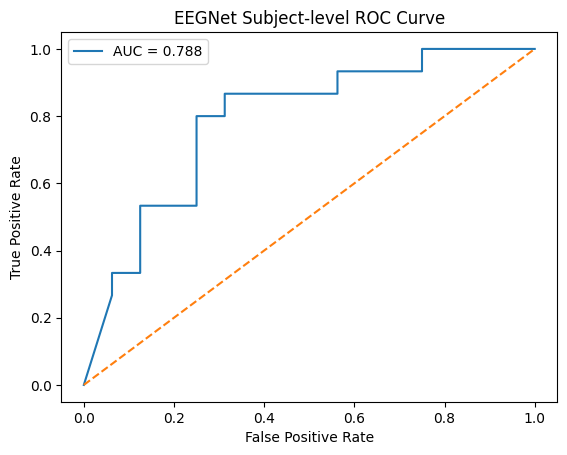

In [1]:
# EDA Cell 1 — EEGNet Subject-level ROC

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

results = list(np.load("EEGNet_LOSO/loso_results.npy", allow_pickle=True))

y_true_subj = []
y_prob_subj = []
for r in results:
    y_true_subj.append(int(r["y_true"][0]))
    y_prob_subj.append(np.mean(r["y_prob"]))

y_true_subj = np.array(y_true_subj)
y_prob_subj = np.array(y_prob_subj)

fpr, tpr, _ = roc_curve(y_true_subj, y_prob_subj)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EEGNet Subject-level ROC Curve")
plt.legend()
plt.show()

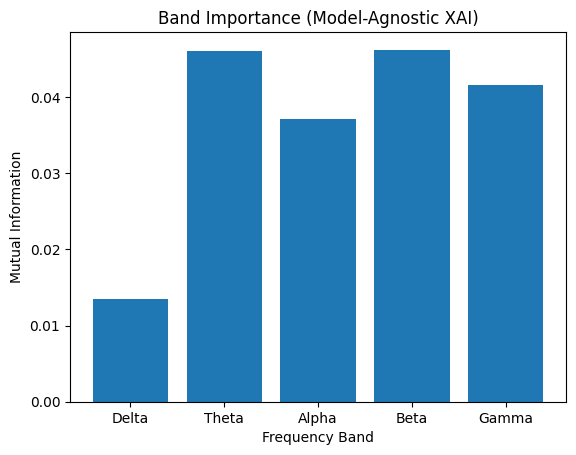

Most informative band: Beta


In [2]:
# EDA Cell 2 — Band Importance

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

X_feats = np.load("ML_BASELINE/X_bandpower.npy")
y = np.load("ML_BASELINE/y.npy")

n_channels = 40
n_bands = 5
band_names = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

mi = mutual_info_classif(X_feats, y, random_state=42)
mi = mi.reshape(n_channels, n_bands)
band_importance = mi.mean(axis=0)

plt.figure()
plt.bar(band_names, band_importance)
plt.xlabel("Frequency Band")
plt.ylabel("Mutual Information")
plt.title("Band Importance (Model-Agnostic XAI)")
plt.show()

best_band_idx = int(np.argmax(band_importance))
best_band_name = band_names[best_band_idx]
print("Most informative band:", best_band_name)

/var/folders/lf/qc_zbjws63q9y9z07849hwwc0000gn/T/ipykernel_27862/3370052582.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([hc_vals, pd_vals], labels=["HC", "PD"])


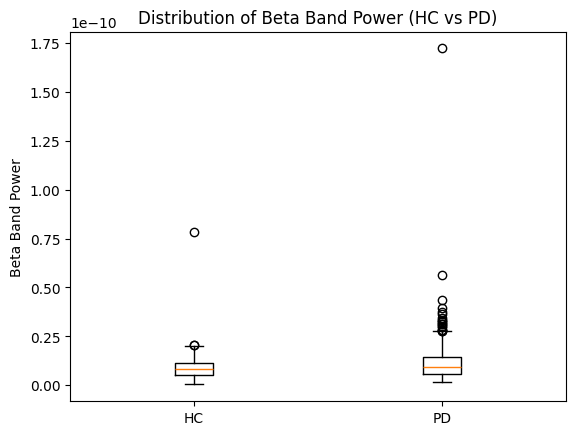

In [3]:
# EDA Cell 3 — Band Distribution (HC vs PD)

# Recompute band importance index if needed
best_band_idx = int(np.argmax(band_importance))
best_band_name = band_names[best_band_idx]

band_values = []
for i in range(n_channels):
    band_values.append(X_feats[:, i*n_bands + best_band_idx])
band_values = np.mean(np.vstack(band_values), axis=0)

pd_vals = band_values[y == 1]
hc_vals = band_values[y == 0]

plt.figure()
plt.boxplot([hc_vals, pd_vals], labels=["HC", "PD"])
plt.ylabel(f"{best_band_name} Band Power")
plt.title(f"Distribution of {best_band_name} Band Power (HC vs PD)")
plt.show()

In [4]:
import os
os.makedirs("FIGURES", exist_ok=True)
print("FIGURES folder ready")

FIGURES folder ready


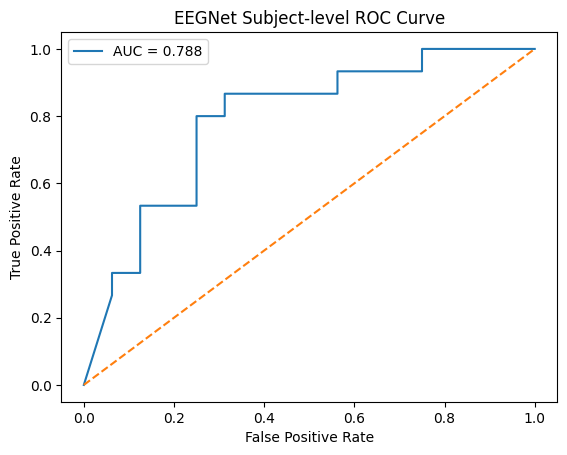

Saved: FIGURES/roc_eegnet.png


In [5]:
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EEGNet Subject-level ROC Curve")
plt.legend()

plt.savefig("FIGURES/roc_eegnet.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: FIGURES/roc_eegnet.png")

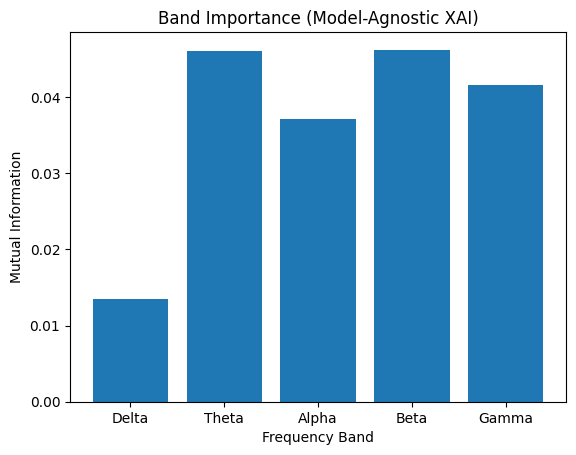

Saved: FIGURES/band_importance.png


In [6]:
plt.figure()
plt.bar(band_names, band_importance)
plt.xlabel("Frequency Band")
plt.ylabel("Mutual Information")
plt.title("Band Importance (Model-Agnostic XAI)")

plt.savefig("FIGURES/band_importance.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: FIGURES/band_importance.png")

/var/folders/lf/qc_zbjws63q9y9z07849hwwc0000gn/T/ipykernel_27862/3652324503.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([hc_vals, pd_vals], labels=["HC", "PD"])


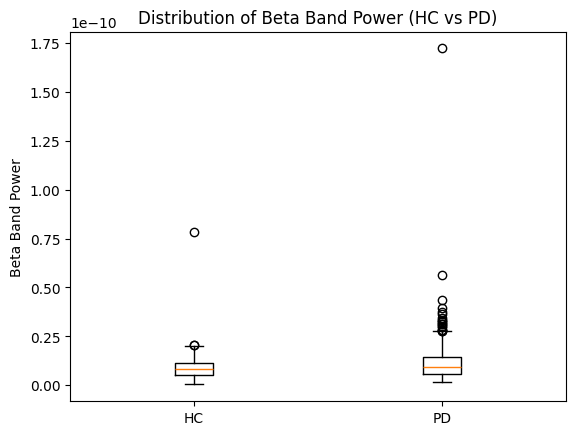

Saved: FIGURES/band_distribution.png


In [7]:
plt.figure()
plt.boxplot([hc_vals, pd_vals], labels=["HC", "PD"])
plt.ylabel(f"{best_band_name} Band Power")
plt.title(f"Distribution of {best_band_name} Band Power (HC vs PD)")

plt.savefig("FIGURES/band_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: FIGURES/band_distribution.png")

In [8]:
plt.savefig("FIGURES/confusion_matrix.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [2]:
# Cell R-1 — Reload saved EEGNet LOSO results

import numpy as np

results = list(np.load("EEGNet_LOSO/loso_results.npy", allow_pickle=True))

y_true_subj = []
y_prob_subj = []

for r in results:
    y_true_subj.append(int(r["y_true"][0]))
    y_prob_subj.append(np.mean(r["y_prob"]))

y_true_subj = np.array(y_true_subj)
y_prob_subj = np.array(y_prob_subj)
y_pred_subj = (y_prob_subj >= 0.5).astype(int)

print("Reloaded subjects:", len(results))
print("y_true_subj shape:", y_true_subj.shape)

Reloaded subjects: 31
y_true_subj shape: (31,)


In [3]:
# Cell R-2 — Save EEGNet subject-level table

import pandas as pd

data = {
    "subject": [r["subject"] for r in results],
    "true_label": y_true_subj,
    "pred_label": y_pred_subj,
    "pred_prob": y_prob_subj
}

df = pd.DataFrame(data)
df.to_csv("RESULTS_eegnet_subject_level.csv", index=False)

print("Saved: RESULTS_eegnet_subject_level.csv")

Saved: RESULTS_eegnet_subject_level.csv


In [4]:
# Cell R-3 — Save summary metrics

import json

summary = {
    "balanced_accuracy": 0.7458,
    "auc": 0.7875,
    "sensitivity": 0.8667,
    "specificity": 0.625,
    "confusion_matrix": {
        "TN": 10,
        "FP": 6,
        "FN": 2,
        "TP": 13
    },
    "CI": {
        "balanced_accuracy_95_CI": [0.5855, 0.8841],
        "auc_95_CI": [0.6009, 0.9316]
    }
}

with open("RESULTS_eegnet_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Saved: RESULTS_eegnet_summary.json")

Saved: RESULTS_eegnet_summary.json


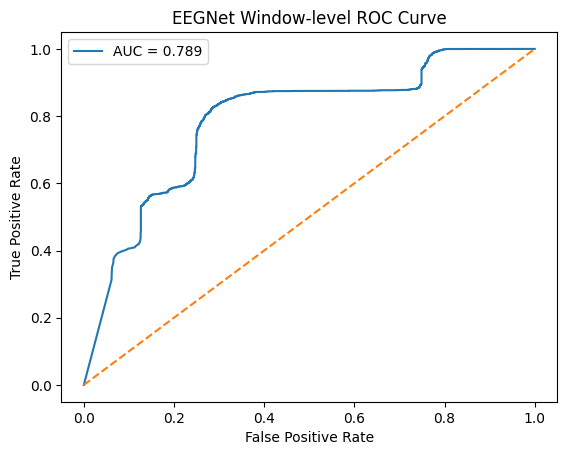

Saved: FIGURES/roc_eegnet_window.png
Window-level AUC: 0.7893


In [5]:
# Cell W-ROC — Window-level ROC curve

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

results = list(np.load("EEGNet_LOSO/loso_results.npy", allow_pickle=True))

y_true_win = []
y_prob_win = []

for r in results:
    y_true_win.extend(r["y_true"])
    y_prob_win.extend(r["y_prob"])

y_true_win = np.array(y_true_win)
y_prob_win = np.array(y_prob_win)

fpr, tpr, _ = roc_curve(y_true_win, y_prob_win)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EEGNet Window-level ROC Curve")
plt.legend()

plt.savefig("FIGURES/roc_eegnet_window.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: FIGURES/roc_eegnet_window.png")
print("Window-level AUC:", round(roc_auc, 4))

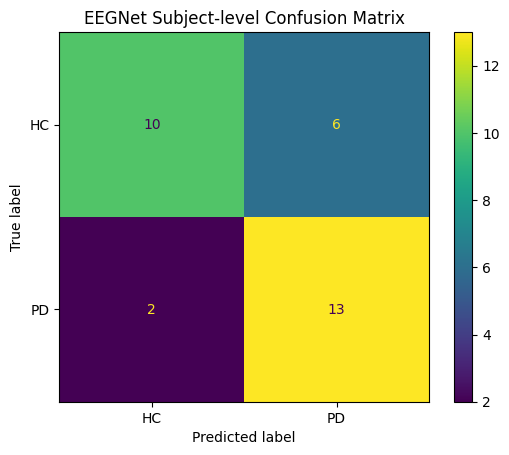

Saved: FIGURES/confusion_matrix.png


In [6]:
# Cell CM-FIG — Confusion matrix figure

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true_subj, y_pred_subj)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HC", "PD"])
disp.plot()

plt.title("EEGNet Subject-level Confusion Matrix")
plt.savefig("FIGURES/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: FIGURES/confusion_matrix.png")

In [7]:
# Cell TABLE — Comparison table

import json
import pandas as pd

# EEGNet numbers (fixed from your results)
eegnet_metrics = {
    "Method": "EEGNet (LOSO)",
    "Balanced_Accuracy": 0.7458,
    "AUC": 0.7875,
    "Sensitivity": 0.8667,
    "Specificity": 0.625
}

# Load ML baseline metrics
with open("ML_BASELINE/ml_metrics.json", "r") as f:
    mlm = json.load(f)

ml_metrics = {
    "Method": "Bandpower + SVM (LOSO)",
    "Balanced_Accuracy": mlm["subject_level_balanced_accuracy"],
    "AUC": mlm["subject_level_auc"],
    "Sensitivity": None,
    "Specificity": None
}

df = pd.DataFrame([eegnet_metrics, ml_metrics])
df.to_csv("RESULTS_comparison_table.csv", index=False)

print(df)
print("Saved: RESULTS_comparison_table.csv")

                   Method  Balanced_Accuracy     AUC  Sensitivity  Specificity
0           EEGNet (LOSO)           0.745800  0.7875       0.8667        0.625
1  Bandpower + SVM (LOSO)           0.714583  0.6500          NaN          NaN
Saved: RESULTS_comparison_table.csv


In [2]:
import mne
print(mne.__version__)

1.11.0
